# Vanguard Portfolio Optimizer (using vanguard historical data)

## Initialization

In [1]:
%matplotlib inline

In [2]:
import requests
import re
import json
import typing

import pandas as pd
import numpy as np
import requests_cache
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
requests_cache.install_cache('requests_cache', backend='sqlite')

In [43]:
PRODUCT_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-list.json"
REQUEST_URL = "https://api.vanguard.com/rs/gre/gra/1.7.0/datasets/urd-product-port-specific-price-history.json?vars=portId:{port_id},issueType:S,startDate:{start_date:%Y-%m-%d},endDate:{end_date:%Y-%m-%d}"
ASSET_COLOURS = {
    "BOND": "red",
    "EQUITY": "green"
}
CUTOFF_YEAR = 2017

END_DATE = pd.to_datetime("2021-11-01")

## Get products descriptions

In [44]:
def get_products() -> pd.DataFrame:
    request = requests.get(PRODUCT_URL)
    assert request.status_code == 200
    return json.loads(request.text)

def len_or(value, none_value=1) -> int:
    return none_value if value is None else len(value)


def products_json_to_df(products_json) -> pd.DataFrame:
    return (
        pd.DataFrame(products_json.values())
        .assign(
            fees=lambda x: x['OCF'].str.slice(0,-1).astype(float) / 100,
            assets= lambda x: x['assetAllocations'].apply(len_or),
            inceptionDate=lambda x: pd.to_datetime(x['inceptionDate'])
        )
        .reset_index(drop=True)
    )
    

raw_products_df = products_json_to_df(get_products())

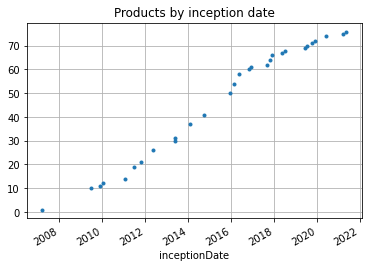

In [45]:
ax = raw_products_df.groupby('inceptionDate').size().sort_index().cumsum().plot(grid=True, style='.')
ax.set_title('Products by inception date');

## Filter products

* Keep only "Accumulation" products (their dividends are automatically reinvsted)
* Remove actively managed products
* Remove ESG/SRI products (they are highly correlated to the non ESG/SRI products)
* Remove recently created products (not enough historical data)

In [46]:
products_df = (
    raw_products_df
    [
        lambda x: 
        (x['distributionStrategyType'] == 'ACCM')
        & (x['managementType'] != 'ACTIVE')
        & ~x['name'].str.startswith('ESG ')
        & ~x['name'].str.startswith('SRI ')
        & (x['inceptionDate'].dt.year <= CUTOFF_YEAR)
        & (x['assetCode'] == 'EQUITY')
    ]
    .reset_index(drop=True)
)

In [47]:
products_df[['name', 'fees', 'inceptionDate']].sort_values('fees', ignore_index=True)

,name,fees,inceptionDate
0,FTSE 100 Index Unit Trust,0.0006,2016-11-08
1,FTSE U.K. All Share Index Unit Trust,0.0006,2009-12-04
2,U.S. Equity Index Fund,0.0010,2009-06-23
3,FTSE Developed Europe ex-U.K. Equity Index Fund,0.0012,2009-06-23
4,FTSE U.K. Equity Income Index Fund,0.0014,2009-06-23
5,FTSE Developed World ex-U.K. Equity Index Fund,0.0014,2009-06-23
6,Japan Stock Index Fund,0.0016,2009-06-23
7,Pacific ex-Japan Stock Index Fund,0.0016,2009-06-23
8,FTSE Global All Cap Index Fund,0.0023,2016-11-08
9,Emerging Markets Stock Index Fund,0.0023,2009-06-23


## Get products historical prices

In [48]:
histories = {}

for _, product in products_df.iterrows():
    port_id = product['portId']
    url = REQUEST_URL.format(
        port_id=port_id,
        start_date=product['inceptionDate'],
        end_date=END_DATE
    )
    request = requests.get(url)
    assert request.status_code == 200
    
    histories[port_id] = json.loads(request.text)



In [49]:
sedols = products_df.set_index('portId')['sedol'].to_dict()
dfs = []
for port_id, history in histories.items():
    df = (
        pd.DataFrame(history)
        .assign(
            date=lambda x: pd.to_datetime(x['date'], utc=True).dt.tz_localize(None).dt.normalize()
        )
        .drop(columns=['mmNavPrice'])
        .rename(columns={'navPrice': 'price'})
        .sort_values('date', ignore_index=True)
        .assign(
            sedol=sedols[port_id],
            day_return=lambda x: (x['price'] - x['price'].shift()) /  x['price'].shift(),
        )
    )
    dfs.append(df)
historical_df = pd.concat(dfs, ignore_index=True)    

## Explore products stats

In [50]:
pivoted_returns = (
    historical_df
        .pivot(index=['date'], columns=['sedol'], values=['day_return'])
        .droplevel(0, axis=1)
        .dropna(how='any')
        [lambda x: sorted(x.columns)]
)

In [51]:
yearly_returns_mean = ((1 + pivoted_returns.mean()) ** 252 -1).rename('yearly_return_mean')
yearly_returns_std = (pivoted_returns.std() * np.sqrt(252)).rename('yearly_return_std')
counts = pivoted_returns.count().rename('count')

stats = pd.concat([yearly_returns_mean, yearly_returns_std, counts], axis=1)

In [52]:
products_stats_df = products_df.join(stats, on='sedol')

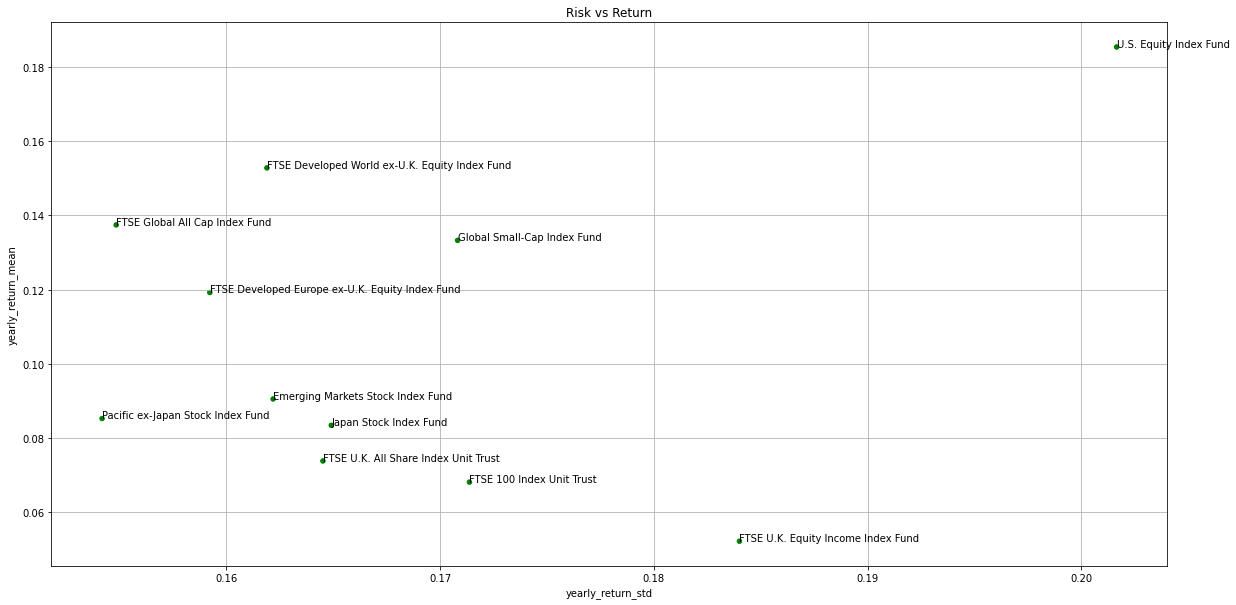

In [53]:
ax = (
    products_stats_df
    #.set_index('year_std')
    .plot.scatter(
        x='yearly_return_std',
        y='yearly_return_mean',
        grid=True,
        figsize=(20, 10),
        c=products_stats_df['assetCode'].map(ASSET_COLOURS)
    )
)

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

label_point(
    products_stats_df['yearly_return_std'], 
    products_stats_df['yearly_return_mean'], 
    products_stats_df['name'], 
    ax
)
_ = ax.set_title("Risk vs Return")

In [54]:
pivoted_prices = (
    historical_df
    .pivot(index='date', values='price', columns='sedol')
    .dropna(how='any')
)

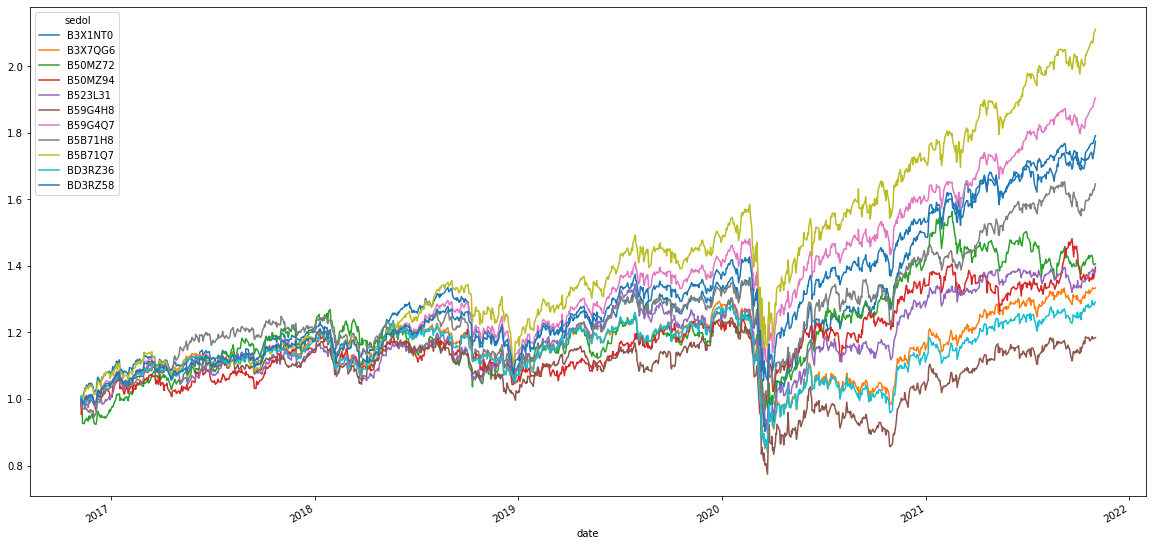

In [55]:
_ = (
    pivoted_prices
    .div(pivoted_prices.iloc[0], axis=1)
    .plot(figsize=(20,10))
)

## Prepare optimization inputs

In [56]:
covariance = (
        pivoted_returns.cov().sort_index()[lambda x: sorted(x.columns)]
)
expected_returns = pivoted_returns.mean()

In [57]:
class ProblemVariables:
    
    def __init__(self, expected_returns, covariance):
        
        assert (expected_returns.index == covariance.index).all()
        self.index = expected_returns.index
        er = expected_returns.to_numpy()
        cov = np.asmatrix(covariance.to_numpy())
        self.x = cp.Variable(len(expected_returns))
        self.vol = cp.quad_form(self.x, np.asmatrix(cov))
        self.ret = er.T @ self.x
        
    def results(self):
        return self.ret.value, self.std()
    
    def std(self):
        return np.sqrt(self.vol.value)
        
    
    def year_std(self):
        return self.std() * np.sqrt(252)
    
    def year_return(self):
        return (1 + self.ret.value)**252 - 1
    
    def full_results(self):
        results = dict(zip(self.index, self.x.value))
        results['return'] = self.year_return()
        results['std'] = self.year_std()
        return pd.Series(results)
    
    def maximize_returns(self):
        cp.Problem(cp.Maximize(self.ret), [sum(self.x) == 1, self.x >= 0]).solve(solver='CVXOPT')
        return self
        
    def minimize_std(self):
        cp.Problem(cp.Minimize(self.vol), [sum(self.x) == 1, self.x >= 0]).solve(solver='CVXOPT')
        return self

    def solve_for_std(self, std_limit):
        cp.Problem(
            cp.Maximize(self.ret),
              [
                  self.vol <= std_limit**2,
                  cp.sum(self.x) == 1, 
                  self.x >= 0,
              ]
         ).solve(solver='CVXOPT')
        return self
        
    def iterate_stds(self, points):
        min_std = self.minimize_std().std()
        max_std = self.maximize_returns().std()
        
        std_values = np.linspace(min_std, max_std, points)
        results = []
        for std_limit in std_values:
            results.append(self.solve_for_std(std_limit).full_results())
        return pd.DataFrame(results)

    def solve_for_return(self, return_limit):
        prob = cp.Problem(
            cp.Minimize(self.vol),
              [
                  self.ret >= return_limit,
                  cp.sum(self.x) == 1, 
                  self.x >= 0,
              ]
         ).solve(solver='CVXOPT')
        return self
    
    def iterate_returns(self, points):
        min_return = self.minimize_std().ret.value
        max_return = self.maximize_returns().ret.value
        
        return_values = np.linspace(min_return, max_return, points)
        
        results = []
        for return_value in return_values:
            results.append(self.solve_for_return(return_value).full_results())
        return pd.DataFrame(results)

std_ptfs = ProblemVariables(expected_returns, covariance).minimize_std().iterate_stds(200)

## Plot results

In [58]:
def renormalize(df):
    row_sum = df.sum(axis=1)
    return df.div(row_sum, axis=0)


def plot_ptfs(ptfs, products_df, key='std'):
    assert key in ('std', 'return')
    mapping = products_df.set_index('sedol')['name'].to_dict()

    return (
        ptfs
        .drop(columns=['return' if key == 'std' else 'std'])
        .set_index('std' if key == 'std' else 'return')
        .mask(lambda x: x < 0.01)
        .fillna(0)
        .loc[:, lambda x:(x != 0).any(axis=0)]
        .pipe(renormalize)
        .rename(columns=mapping)
        .plot
        .area(figsize=[20,10], grid=True, legend='reverse')
    )

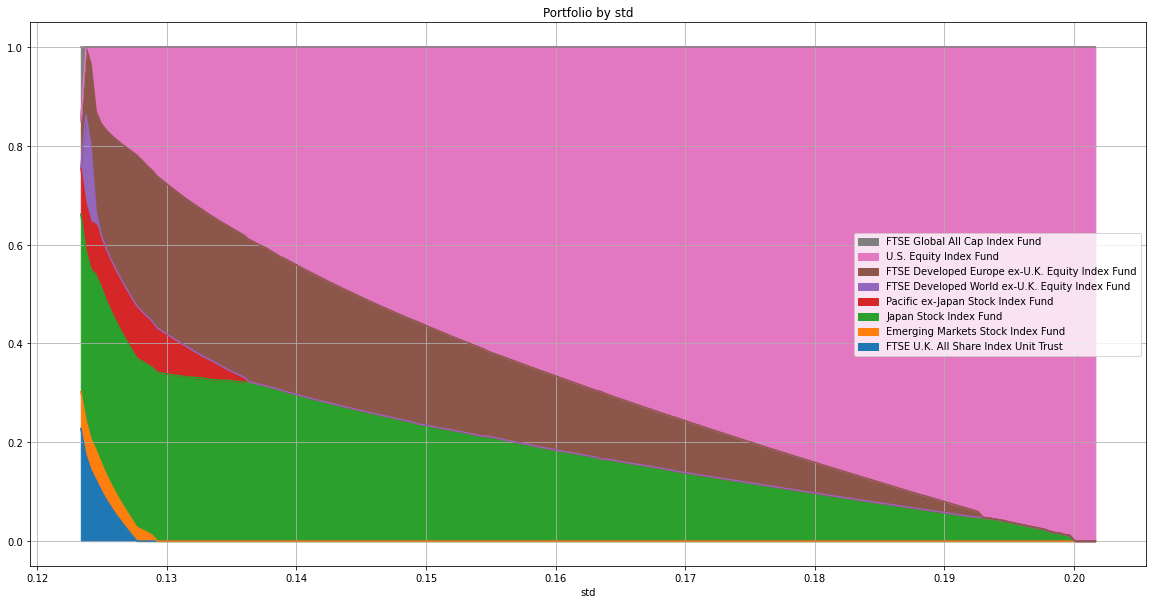

In [59]:
_ = plot_ptfs(std_ptfs, products_df, key='std').set_title("Portfolio by std")

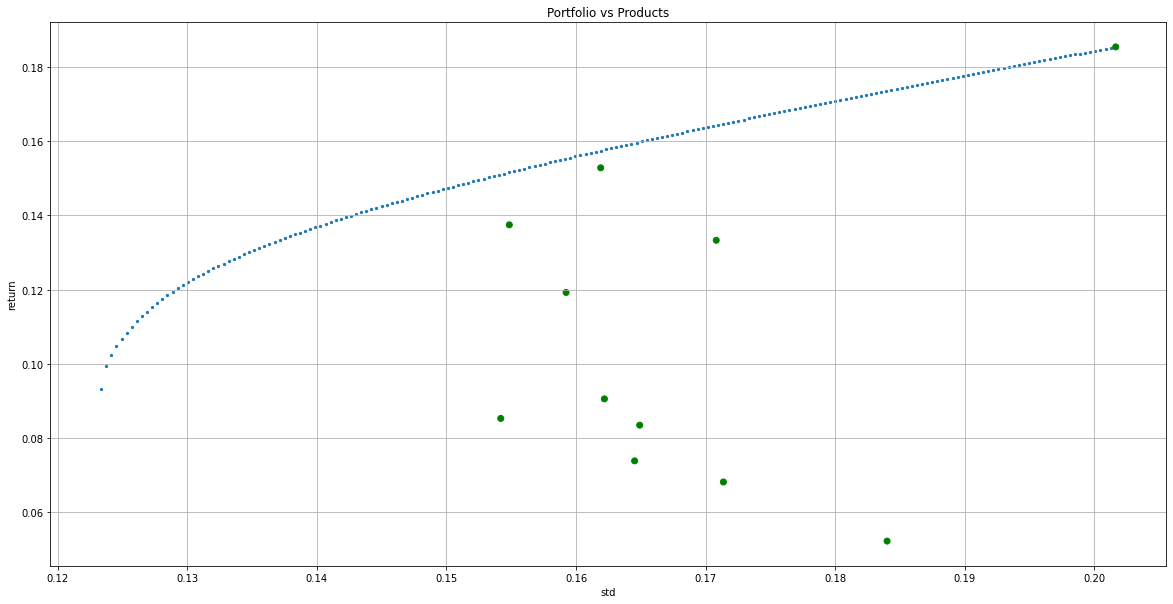

In [60]:
ax = (
    std_ptfs
    .plot.scatter(x='std', y='return', grid=True, marker='.', figsize=(20,10))
)
ax.scatter(
    x=products_stats_df['yearly_return_std'], 
    y=products_stats_df['yearly_return_mean'],
    c=products_stats_df['assetCode'].map(ASSET_COLOURS))
_ = ax.set_title('Portfolio vs Products')

# Appendix 1: identifying redundant products

In [61]:
marginal_vifs = (
    pd.Series(
        [
            variance_inflation_factor(pivoted_returns.values, i)
            for i in range(len(pivoted_returns.columns))
        ],
        index=pivoted_returns.columns
    )
    .sort_values()
    .rename('vif')
    .to_frame()
    .join(products_df.set_index('sedol')[['name']])
)
marginal_vifs

,vif,name
sedol,,
B523L31,4.163307,Pacific ex-Japan Stock Index Fund
B50MZ94,7.475556,Japan Stock Index Fund
B50MZ72,7.603024,Emerging Markets Stock Index Fund
B59G4H8,8.368831,FTSE U.K. Equity Income Index Fund
B3X7QG6,11.816539,FTSE U.K. All Share Index Unit Trust
BD3RZ36,13.701614,FTSE 100 Index Unit Trust
B3X1NT0,18.952576,Global Small-Cap Index Fund
B5B71H8,20.655631,FTSE Developed Europe ex-U.K. Equity Index Fund
B5B71Q7,414.021436,U.S. Equity Index Fund


In [62]:
def calculate_vifs(pr):
    removed = {}
    for i in range(len(pr.columns) -1):
        vif = (
            pd.Series(
                [
                    variance_inflation_factor(pr.values, i)
                    for i in range(len(pr.columns))
                ],
                index=pr.columns
            )
            .sort_values()
            .rename('vif')
        )
        removed[vif.index[-1]] = vif.iloc[-1]
        
        pr = pr[lambda x: [c for c in x.columns if c not in removed]]
    removed[pr.columns[0]] = 1
    return pd.Series(removed, name='vif').sort_values()
                
recursive_vifs = (
    calculate_vifs(pivoted_returns)
    .to_frame()
    .rename_axis("sedol")
    .join(products_df.set_index('sedol')[['name']])
)
recursive_vifs

,vif,name
sedol,,
B50MZ94,1.000000,Japan Stock Index Fund
B59G4H8,1.028748,FTSE U.K. Equity Income Index Fund
B5B71Q7,1.367882,U.S. Equity Index Fund
B50MZ72,1.810510,Emerging Markets Stock Index Fund
B523L31,2.624968,Pacific ex-Japan Stock Index Fund
B5B71H8,3.490388,FTSE Developed Europe ex-U.K. Equity Index Fund
B3X7QG6,8.283066,FTSE U.K. All Share Index Unit Trust
B3X1NT0,8.841064,Global Small-Cap Index Fund
BD3RZ36,13.478138,FTSE 100 Index Unit Trust


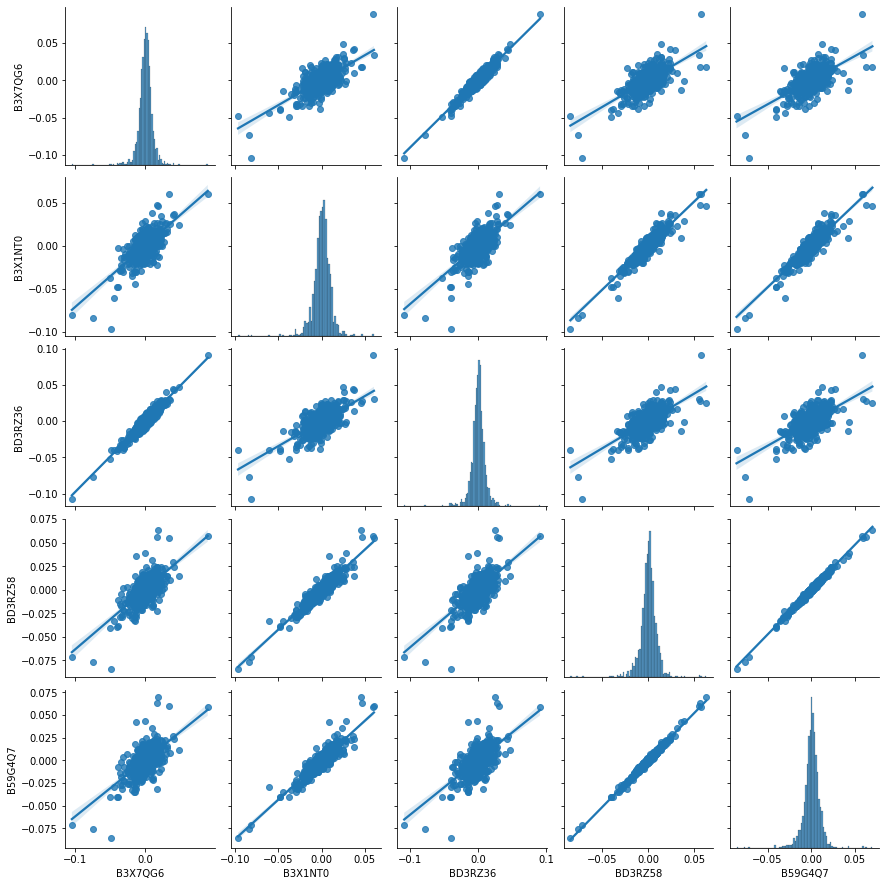

In [63]:
pg = sns.pairplot(pivoted_returns[recursive_vifs.index[-5:]], kind="reg")

# Appendix 2: Heat Map

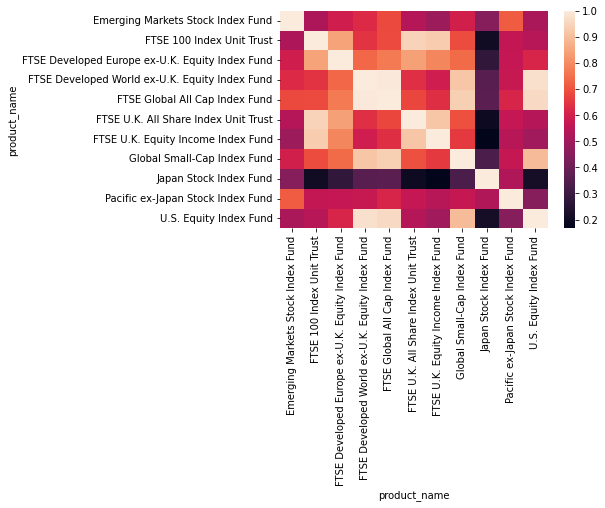

In [64]:
correlation = (
    pivoted_returns
    .rename(columns=products_df.set_index('sedol')['name'].to_dict())
    .rename_axis("product_name", axis=1)
    .corr().sort_index()[lambda x: sorted(x.columns)]
)
_ = sns.heatmap(correlation)

# Appendix 3: PCA

In [69]:
from sklearn.decomposition import PCA

returns_by_name = pivoted_returns.rename(columns=products_df.set_index('sedol')['name'].to_dict())

components_number = 5
pca = PCA(n_components=components_number)
X = returns_by_name[lambda x: ~x.isnull().any(axis=1)].to_numpy().T
X = X / X.std()
components = pca.fit_transform(X)
principal_df = pd.DataFrame(data = components, columns = [str(i + 1) for i in range(0, components_number)])
principal_df.set_index(returns_by_name.columns)

,1,2,3,4,5
sedol,,,,,
Global Small-Cap Index Fund,-0.932674,11.559498,-2.337425,1.459092,-1.079858
FTSE U.K. All Share Index Unit Trust,-13.527584,-9.208790,-1.527275,-0.044881,-0.868905
Emerging Markets Stock Index Fund,11.000195,-5.150882,16.662066,-8.411960,-4.680309
Japan Stock Index Fund,27.762286,-12.631065,-13.745133,-2.144864,-1.996773
Pacific ex-Japan Stock Index Fund,10.854231,-10.198100,8.716899,12.930093,4.912290
FTSE U.K. Equity Income Index Fund,-17.298266,-10.829834,-2.229681,2.544909,-6.191693
FTSE Developed World ex-U.K. Equity Index Fund,2.319020,13.767841,-1.248862,0.051516,0.925772
FTSE Developed Europe ex-U.K. Equity Index Fund,-7.418902,-4.106003,-1.140942,-7.623525,11.406417
U.S. Equity Index Fund,-0.093428,24.906845,-0.940004,1.786835,-1.626853


<AxesSubplot:>

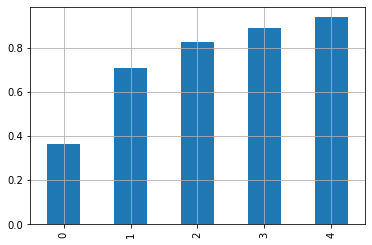

In [74]:
pd.Series(pca.explained_variance_ratio_).cumsum().plot.bar(grid=True)